## Deep Learning Multiclass Challenge (CAD Project)

Author: **Muhammad Zain Amin**
<br>
Erasmus Mundus Joint Master Degree in Medical Imaging and Applications (MAIA)
<br>
University of Girona, Spain

#### Libraries

In [ ]:
import copy
import time
import sys
import logging
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageOps
from typing import Optional, Sequence

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from skimage import io

#### Import Functions and Classes

In [20]:
from imshow import imshow
from visualize_model import visualize_model
from focal_loss import FocalLoss
from train_model import train_model
from test_model import test_model
from plot_confusion_matrix import plot_confusion_matrix
from plot_roc import plot_roc
from Imbalanced_Dataset_Sampler import ImbalancedDatasetSampler 
from Challenge_2_Dataset import Challenge2Dataset
from Data_Samples import get_samples_count
from models import ModelFactory

#### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Ensembles Results

#### Load the Saved Models for Ensembles

In [ ]:
model_factory = ModelFactory()

In [ ]:
swin_1 = model_factory.make_swin(False, DEVICE)
swin_1.load_state_dict(torch.load('/content/drive/MyDrive/CAD/swin_ce_sampling_best.pth'))

<All keys matched successfully>

In [ ]:
swin_2 = model_factory.make_swin_s(False, DEVICE)
swin_2.load_state_dict(torch.load('/content/drive/MyDrive/CAD/swin_s_ce_best.pth'))

<All keys matched successfully>

In [ ]:
swin_3 = model_factory.make_swin_v2(False, DEVICE)
swin_3.load_state_dict(torch.load('/content/drive/MyDrive/CAD/swin_s_v2_ce_best.pth'))

<All keys matched successfully>

In [ ]:
swin_4 = model_factory.make_swin_v2_b(False, DEVICE)
swin_4.load_state_dict(torch.load('/content/drive/MyDrive/CAD/swin_b_v2_ce_best.pth'))

<All keys matched successfully>

In [ ]:
efficientnet = model_factory.make_efficientnet(False, DEVICE)
efficientnet.load_state_dict(torch.load('/content/drive/MyDrive/CAD/efficientnet_ce_sampling_best.pth'))

<All keys matched successfully>

In [ ]:
resnet = model_factory.make_resnet(False, DEVICE)
resnet.load_state_dict(torch.load('/content/drive/MyDrive/CAD/ResNet/resnet_ce_samp_best.pth'))

<All keys matched successfully>

#### Ensemble of Swin Tiny + Swin S + Swin V2 S + Swin V2 B Transformers

In [ ]:
since = time.time()

swin_1.eval()
swin_2.eval()
swin_3.eval()
swin_4.eval()

running_labels = []
running_preds = []

# Iterate over data.
with torch.no_grad():
    for batch in tqdm(val_loader):
        inputs = batch["image"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        outputs_1 = swin_1(inputs)
        outputs_2 = swin_2(inputs)
        outputs_3 = swin_3(inputs)
        outputs_4 = swin_4(inputs)
        outputs = (outputs_1 + outputs_2 + outputs_3 + outputs_4) / 4.0
        _, preds = torch.max(outputs, 1)
        running_labels = running_labels + labels.int().cpu().tolist()
        running_preds = running_preds + preds.int().cpu().tolist()
    test_kappa = cohen_kappa_score(running_labels, running_preds)
    test_acc = accuracy_score(running_labels, running_preds)
    print(f'Test Acc: {test_acc:.4f}, kappa: {test_kappa:.4f}')
    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

100%|██████████| 20/20 [00:35<00:00,  1.76s/it]

Test Acc: 0.9740, kappa: 0.9534
Testing complete in 0m 35s


Confusion matrix, without normalization
[[663   9   6]
 [  7 486   5]
 [  3   3  88]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

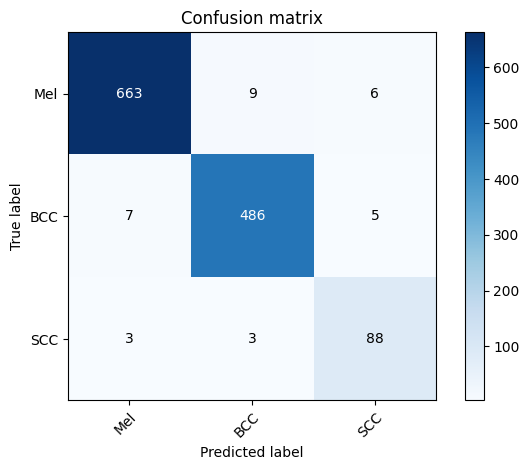

In [ ]:
plot_confusion_matrix(running_labels, running_preds, ['Mel', 'BCC', 'SCC'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

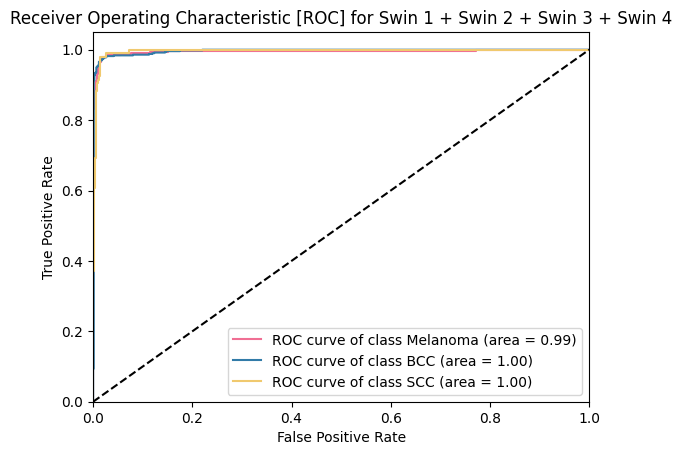

{0: 0.9941675635812804, 1: 0.9959449195746717, 2: 0.9962006079027356}

In [ ]:
probas = np.vstack(outputs_all)
plot_roc(running_labels, probas, True, 'Swin 1 + Swin 2 + Swin 3 + Swin 4')

#### Ensemble of Swin S + Swin V2 S + Swin V2 B Transformers

In [ ]:
since = time.time()

swin_2.eval()
swin_3.eval()
swin_4.eval()
running_labels = []
running_preds = []

# Iterate over data.
with torch.no_grad():
    for batch in tqdm(val_loader):
        inputs = batch["image"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        outputs_1 = swin_2(inputs)
        outputs_2 = swin_3(inputs)
        outputs_3 = swin_4(inputs)
        outputs = (outputs_1 + outputs_2 + outputs_3) / 3.0
        _, preds = torch.max(outputs, 1)
        running_labels = running_labels + labels.int().cpu().tolist()
        running_preds = running_preds + preds.int().cpu().tolist()
    test_kappa = cohen_kappa_score(running_labels, running_preds)
    test_acc = accuracy_score(running_labels, running_preds)
    print(f'Test Acc: {test_acc:.4f}, kappa: {test_kappa:.4f}')
    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

100%|██████████| 20/20 [00:38<00:00,  1.92s/it]

Test Acc: 0.9732, kappa: 0.9520
Testing complete in 0m 38s


Confusion matrix, without normalization
[[663   8   7]
 [  7 486   5]
 [  4   3  87]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

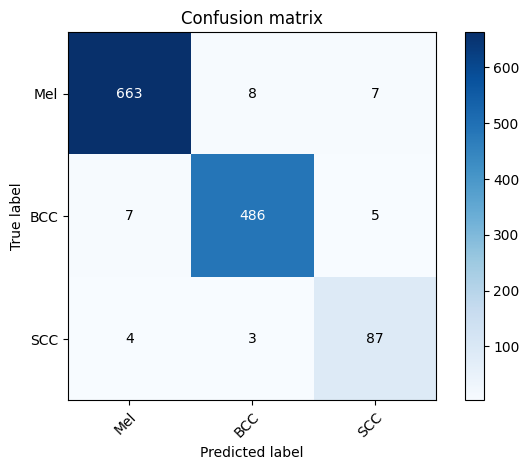

In [ ]:
plot_confusion_matrix(running_labels, running_preds, ['Mel', 'BCC', 'SCC'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

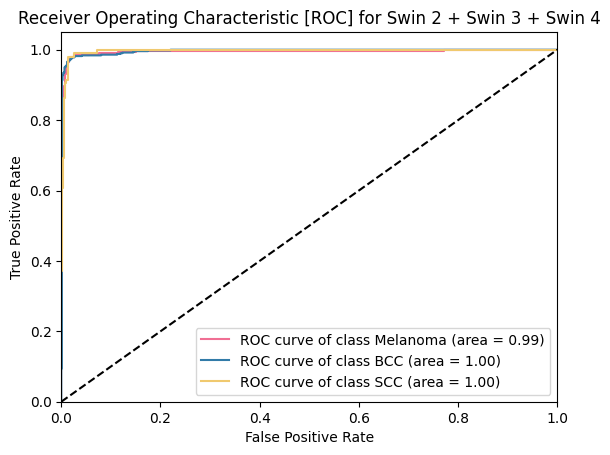

{0: 0.9941675635812804, 1: 0.9959449195746717, 2: 0.9962006079027356}

In [ ]:
probas = np.vstack(outputs_all)
plot_roc(running_labels, probas, True, 'Swin 2 + Swin 3 + Swin 4')

#### Ensemble of ResNet50 + Swin S + Swin V2 S + Swin V2 B Transformers

In [ ]:
since = time.time()

resnet.eval()
swin_2.eval()
swin_3.eval()
swin_4.eval()
running_labels = []
running_preds = []

# Iterate over data.
with torch.no_grad():
    for batch in tqdm(val_loader):
        inputs = batch["image"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        outputs_0 = resnet(inputs)
        outputs_1 = swin_2(inputs)
        outputs_2 = swin_3(inputs)
        outputs_3 = swin_4(inputs)
        outputs = (outputs_0 + outputs_1 + outputs_2 + outputs_3) / 4.0
        _, preds = torch.max(outputs, 1)
        running_labels = running_labels + labels.int().cpu().tolist()
        running_preds = running_preds + preds.int().cpu().tolist()
    test_kappa = cohen_kappa_score(running_labels, running_preds)
    test_acc = accuracy_score(running_labels, running_preds)
    print(f'Test Acc: {test_acc:.4f}, kappa: {test_kappa:.4f}')
    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

100%|██████████| 20/20 [00:38<00:00,  1.93s/it]

Test Acc: 0.9748, kappa: 0.9547
Testing complete in 0m 39s


Confusion matrix, without normalization
[[664   9   5]
 [  7 487   4]
 [  4   3  87]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

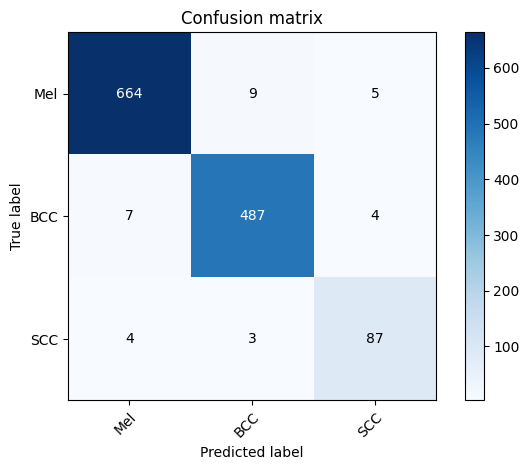

In [ ]:
plot_confusion_matrix(running_labels, running_preds, ['Mel', 'BCC', 'SCC'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

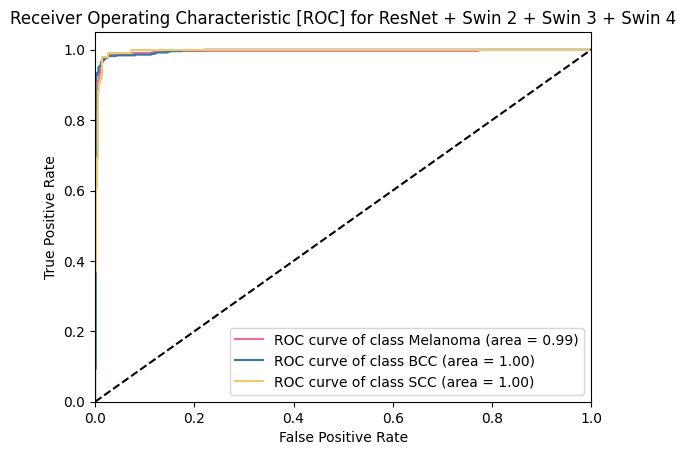

{0: 0.9941675635812804, 1: 0.9959449195746717, 2: 0.9962006079027356}

In [ ]:
probas = np.vstack(outputs_all)
plot_roc(running_labels, probas, True, 'ResNet + Swin 2 + Swin 3 + Swin 4')

#### Ensemble of EfficientNet B1 + Swin S + Swin V2 S + Swin V2 B Transformers

In [ ]:
since = time.time()

efficientnet.eval()
swin_2.eval()
swin_3.eval()
swin_4.eval()
running_labels = []
running_preds = []

# Iterate over data.
with torch.no_grad():
    for batch in tqdm(val_loader):
        inputs = batch["image"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        outputs_0 = efficientnet(inputs)
        outputs_1 = swin_2(inputs)
        outputs_2 = swin_3(inputs)
        outputs_3 = swin_4(inputs)
        outputs = (outputs_0 + outputs_1 + outputs_2 + outputs_3) / 4.0
        _, preds = torch.max(outputs, 1)
        running_labels = running_labels + labels.int().cpu().tolist()
        running_preds = running_preds + preds.int().cpu().tolist()
    test_kappa = cohen_kappa_score(running_labels, running_preds)
    test_acc = accuracy_score(running_labels, running_preds)
    print(f'Test Acc: {test_acc:.4f}, kappa: {test_kappa:.4f}')
    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

100%|██████████| 20/20 [00:31<00:00,  1.59s/it]

Test Acc: 0.9780, kappa: 0.9604
Testing complete in 0m 32s


Confusion matrix, without normalization
[[666   6   6]
 [  7 488   3]
 [  3   3  88]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

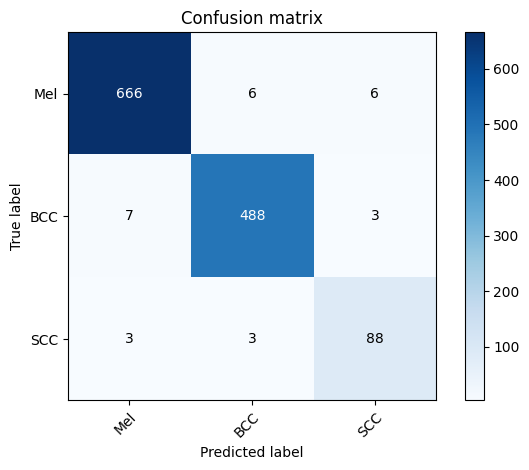

In [ ]:
plot_confusion_matrix(running_labels, running_preds, ['Mel', 'BCC', 'SCC'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

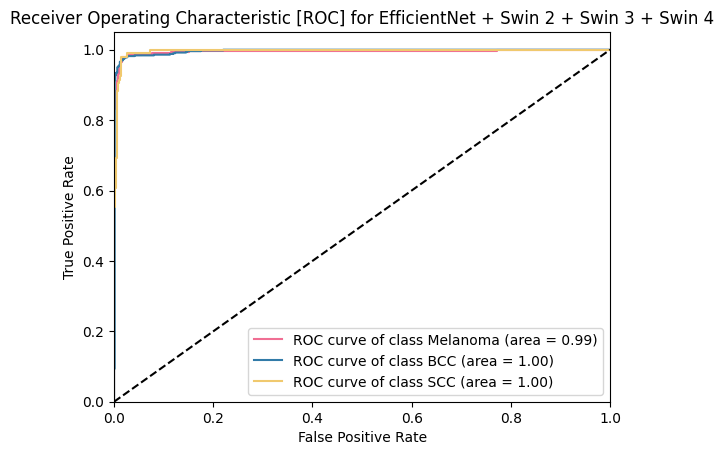

{0: 0.9941675635812804, 1: 0.9959449195746717, 2: 0.9962006079027356}

In [ ]:
probas = np.vstack(outputs_all)
plot_roc(running_labels, probas, True, 'EfficientNet + Swin 2 + Swin 3 + Swin 4')

In [ ]:
test_df = pd.read_csv(test_csv_path)
test_ids = []
test_preds = []
for i, row in test_df.iterrows():
  img_id = '/' + row['Image_ID'] 

  img_path = test_img_folder + img_id + '.jpg' 
  image = Image.open(img_path)  
  image = img_transforms(image).unsqueeze(0).to(DEVICE)

  outputs_1 = efficientnet(image)
  outputs_2 = swin_2(image)
  outputs_3 = swin_3(image)
  outputs_4 = swin_4(image)
  outputs = (outputs_1 + outputs_2 + outputs_3 + outputs_4) / 4.0
  _, preds = torch.max(outputs, 1)
  test_preds = test_preds + preds.int().cpu().tolist()
  test_ids.append(img_id)
  print(f"Image {row['Image_ID']} done")

Image xxx01102 done
Image xxx01122 done
Image xxx01137 done
Image xxx01096 done
Image xxx01126 done
Image xxx01121 done
Image xxx01089 done
Image xxx01095 done
Image xxx01087 done
Image xxx01109 done
Image xxx01110 done
Image xxx01107 done
Image xxx01091 done
Image xxx01125 done
Image xxx01082 done
Image xxx01101 done
Image xxx01156 done
Image xxx01195 done
Image xxx01158 done
Image xxx01180 done
Image xxx01181 done
Image xxx01189 done
Image xxx01188 done
Image xxx01148 done
Image xxx01162 done
Image xxx01182 done
Image xxx01147 done
Image xxx01179 done
Image xxx01138 done
Image xxx01170 done
Image xxx01171 done
Image xxx01174 done
Image xxx01160 done
Image xxx01164 done
Image xxx01161 done
Image xxx01173 done
Image xxx01153 done
Image xxx01178 done
Image xxx01145 done
Image xxx01152 done
Image xxx01142 done
Image xxx01191 done
Image xxx01143 done
Image xxx01193 done
Image xxx01155 done
Image xxx01194 done
Image xxx01200 done
Image xxx01184 done
Image xxx01196 done
Image xxx01144 done


In [ ]:
test_dict = {'img_id': test_ids, 'prediction': test_preds}
test_inf_df = pd.DataFrame(test_dict)
test_inf_df.to_csv('/content/drive/MyDrive/CAD/test_results_best.csv')